In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
import sklearn

from importlib import reload

#import process_gini as pg
#import plots
#import model as m

In [2]:
path = "../data/skylab_instagram_datathon_dataset.csv"
df = pd.read_csv(path.replace("/", os.sep), sep=";")

string_vars = ["compset_group", "compset", "business_entity_doing_business_as_name",
"legal_entity_name", "domicile_country_name", "ultimate_parent_legal_entity_name",
"primary_exchange_name"]

for varname in df.columns:
    # 1. remove leading and trailing whitespaces and convert to lowercase
    df[varname] = df[varname].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
    # 2. replace all double whitespaces with single whitespaces
    df[varname] = df[varname].apply(lambda x: x.replace("  ", " ") if isinstance(x, str) else x)

# Was paying for this dataset worth it?
<img src="../pics/dune_img1.jpg"/>

1. [About the data](#About-the-data)
2. [Data Analysis](#Data-Analysis)
   1. [Subsection A](#Subsection-A)
   2. [Subsection B](#Subsection-B)
3. [Conclusion](#Conclusion)

## About the data

Before getting into the results. Let's have a look at the given dataset

In [3]:
shape = df.shape
print(f"Not to bore you, here are only a few facts:\n")
print(f"The dataset has {shape[0]} rows and {shape[1]} columns.")
print(f"It consists of the date after the data was collected over a week.")
print("By data we mean information about the Instagram account such as number of follower, number of comments, number of likes and so on.")
print("For the interested reader check out the column names:")

df.describe(include = "all").fillna(0)

Not to bore you, here are only a few facts:

The dataset has 704313 rows and 15 columns.
It consists of the date after the data was collected over a week.
By data we mean information about the Instagram account such as number of follower, number of comments, number of likes and so on.
For the interested reader check out the column names:


,period,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,domicile_country_name,ultimate_parent_legal_entity_name,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
count,704313,704313,704313,704313,704313,676558,458589,676558,458589,704313,5.792580e+05,695803.000000,684349.000000,6.953430e+05,6.959770e+05
unique,1,455,20,54,706,423,26,401,30,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
top,weekly,2023-07-08,luxury & premium & mainstream,us softlines analyst interest list,all brands,lvmh moet hennessy louis vuitton se,united states of america,lvmh moet hennessy louis vuitton se,new york stock exchange,metric value,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
freq,704313,1635,216241,113744,27755,27576,193509,27576,132071,704313,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
mean,0,0,0,0,0,0,0,0,0,0,1.342432e+07,344.272540,61.244426,3.043246e+04,2.163189e+06
std,0,0,0,0,0,0,0,0,0,0,1.106975e+08,2777.396873,564.468480,2.766459e+05,1.803193e+07
min,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0,0,0,0,0,0,0,0,0,0,3.013372e+05,19.000000,2.000000,3.710000e+02,1.727700e+04
50%,0,0,0,0,0,0,0,0,0,0,1.104144e+06,44.000000,7.000000,1.435000e+03,9.318400e+04
75%,0,0,0,0,0,0,0,0,0,0,4.479325e+06,122.000000,20.000000,5.872000e+03,4.577470e+05


## Data processing
Before generating any model, the data needs to be prepared to be able to run in a model.

<div class="alert alert-block alert-warning">
For details about the code please checkout code/data_creation.ipynb.
</div>

### Data cleaning

#### Static columns

There are 2 columns in this dataset that consist of only one value.
Also the weekday is only one value.

<div class="alert alert-block alert-success">
We can conclude that all data was gathered on Friday's.
</div>

- period: "Weekly"
- calculation_type: "Metric Value"
- Weekday: 5

#### Duplicates

The **major key observation** is that there are entries in the dataset that only differ by the column "compset". 

<div class="alert alert-block alert-danger">
<b>Assumption 1:</b> Certain posts of the account might be advertising in extremely different competition areas.
</div>

Therefore, those rows are merged and for the "compset" the union is taken .

By doing so, the number of rows got reduced by 400'000 rows: from 700'000 to 300'000.

In [4]:
grouping_columns = [col for col in df.columns if col != 'compset']

df.fillna('Group_Null', inplace=True)
result = df.groupby(grouping_columns).agg({'compset': lambda x: set(x)}).reset_index()
df = result
df = df.replace('Group_Null', np.nan)

/tmp/ipykernel_503/3093655397.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Group_Null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Group_Null', inplace=True)
/tmp/ipykernel_503/3093655397.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('Group_Null', np.nan)


There is an entry "All Brands" in the column "business_entity_doing_business_as_name" which has extremely high values.

<div class="alert alert-block alert-danger">
<b>Assumption 2:</b> "All Brands" represent the aggregation of all brands in the corresponding compset.</b>
</div>

In [5]:
df = df[df["business_entity_doing_business_as_name"] != "all brands"]

There is an entry "DO NOT USE" in "ultimate_parent_legal_entity_name". It appears 0.17 % in the dataset.

<div class="alert alert-block alert-danger">
<b>Assumptio 3:</b> We assume "DO NOT USE" only corresponds to not using this specific entry. The row itself can be kept.</b>
</div>
We simply repace this entry with NaN.

In [6]:
df.loc[df["ultimate_parent_legal_entity_name"] == 'do not use', "ultimate_parent_legal_entity_name"] = np.nan

#### Outlier

We have removed every entry consisting of the brand (business_entity_doing_business_as_name) "All Brands". We **assume** it is a summary of all the brands, hence the name. This assumption was **confirmed** by checking out the data.

#### Missing values

<Axes: >

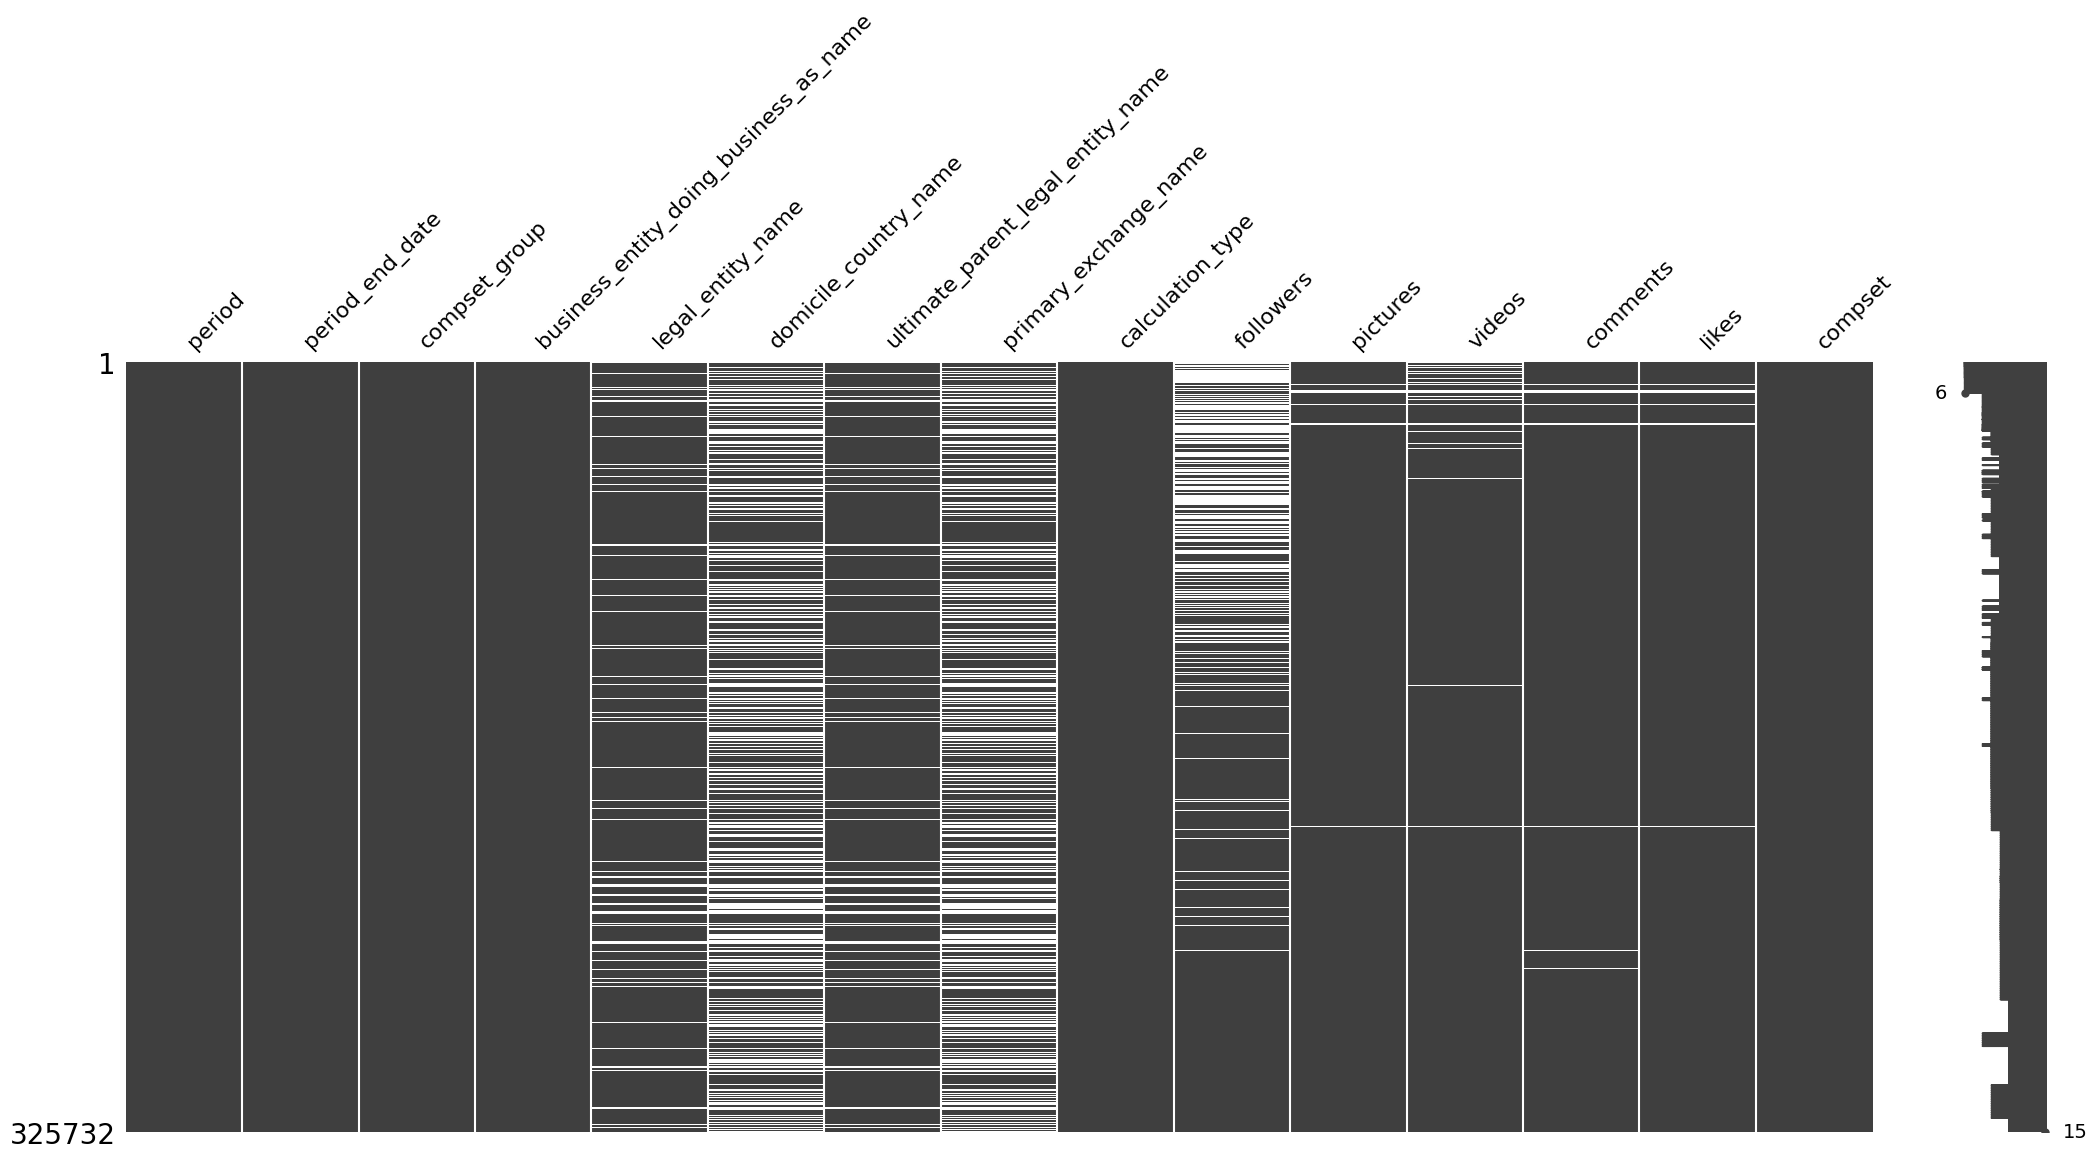

In [6]:
msno.matrix(df)

The above figure demonstrates that the columns "democile_country_name", "primary_exchange_name" and "followers" miss a lot of values.
The following counter measurements were taken:

1. Remove the columns "democile_country_name" and "primary_exchange_name"
2. Impute the missing values of followers by grouping by the date and brand and taking the mean of the two neighbouring values.
    - Do the same for all the other columns that consist of missing values
3. If there is time, find a dataset consisting of the country and brand name.



### Additional features

### Feature engineering

#### Trivial Features

- Year, Month, Day

#### Ownership structure of businesses

The following features display the relationship of the two "A vs. B" entities. Mainly it is whether the legal_entity is owned by either the legal_entity or the business_entity.


- "ultimate_parent_vs_legal_entity"
- "ultimate_parent_vs_business_entity"
- "legal_entity_vs_business_entity"

## Modelling

Here a quick overview what models we used:
- IsolationForest
- SVM
- LOV
- DBSCan
- XGBoost

The main question we want to solve using these models is:
<div class="alert alert-block alert-success">
Can we find any anomalies based on data we were given?
</div>

Here a quick overview what models we used:
- IsolationForest
- SVM
- LOV
- DBSCan
- XGBoost

The main question we want to solve using these models is:
<div class="alert alert-block alert-success">
Can we find any anomalies based on data we were given?
</div>

### Isolation Forest

<div class="alert alert-block alert-warning">
The code for the isolation forest model can be accessed via the file code/model.py.
Due to time reasons it is only on the branch "isolaton_forest"
</div>

We added the preprocessed data into the IsolationForest model. We did a version without hypertuning (next_model) because the kernel crashed when trying to use "optuna", an open-source tool for hypertuning.
In the following, there is a PCA plot that projects the anomalies detected and the normal ones.

What we can conclude is:
<div class="alert alert-block alert-success">
There are more anomalies than normal datapoints when projecting on PCA2.
</div>

<div class="alert alert-block alert-success">
As expected the anomalies are very spread accross the plot.
</div>

<div class="alert alert-block alert-danger">
But there is no obvious pattern visible from anomaly to the normal datapoints...
</div>

**Improvement:**
- Hyperparametertuning was done only quickly. 

```python

def time_based_split(df, date_column, split_ratio=0.8):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.sort_values(by=date_column)
    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]
    return train, test

def next_model(df, features):

    # Example model training
    clf = IsolationForest(random_state=42)
    clf.fit(df)

    # Predict anomalies
    anomalies = clf.predict(df)

    # Add predictions to the original DataFrame
    df['anomaly'] = anomalies

    # Filter the DataFrame to show only the anomalies
    #anomalous_data = df[df['anomaly'] == 1]

    return df
```

### OneClassSVM

Since IsolationForest wasn't very informative, we went on trying a different classification method to find the anomalies, namely OneClassSVM.

<div class="alert alert-block alert-warning">
The detailed implementation can be found in the individualNotebooks/asy_models.ipynb
</div>


<div class="alert alert-block alert-danger">
<b>Assumption: </b> Different subsets of data (different industry, country) have the same distribution of the numberical variables.
</div>

Therefore, we take a random subset to train the algorithm.

For the hyperparameter-tuning we applied gridsearch.

**Improvement**: 
- It would be better to get the whole dataset. The measurements taken above was only due to the time constraint.
- The same goes for the hyperparameter tuning. Usually one should use cross validation...

<div class="alert alert-block alert-danger">
Out of all this model detected 60 % of the dataset as an anomaly.
</div>

This model is definitely horrible, or no obvious patterns with the given features can be found.


### LOF (Local Outlier Factor)

We want to explore a further model. The percentage of number of anomalies detected will be the main metric for comparing these models.

The same as in SVM we only run it on a subset and the detailed code can also be found there.

In the following the number of anomalies detected based on different hyperparameters is shown.

<div class="alert alert-block alert-success">
The hyperparameters have no impact on the number of anomalies detected.
</div>
It could simply be that we haven't tuned enough.

<div class="alert alert-block alert-success">
A bit more than 8 % of the data is detected as an anomaly.
</div>


<img src="../pics/lof.png" />

### DBScan

We have found a model that doesn't think that the data is just "random" (LOF).
What about another model?
The same setup is also used for this model for comparison reasons.

In the following is a table about some results with different hyperparameters:
- The first two columns are hyperparameters.
- pers_outl: is the percentage of data not being an anomaly.
- n_noise: Total predicted number of noise / anomaly.


This model is definitely more prone to the hyperparameters. Why? Sorry no time for answering that :/

The max ratio of outliers: 42 %
The min ratio of outliers: 0.4 %



<img src="../pics/dbscan.jpeg" />

# Modeling and Models

## XGboost / XgRegression:
One of our team's main approaches to the modeling problem was to use the very common learning model XGBoost. Our focus with XGBoost was to add creative and new data columns to our dataframe and watch for improvements. With the wide range of output variables, we used a regression model. This wasn't the first approach we went for, but it was needed. With so many categorical variables, we needed to select which variables we wanted to use with the model for speed and simplicity.

Our main accomplishment with this model was being able to predict our model 5% better with our added variables. The pitfall with this approach was we couldn't classify how to steer our creative search for variables. Our team picked this model for the speed and versatility of XGBoost. We picked it for the classification and influence models, but as the project developed, the models had to be adapted to reality. Our suggestions for model enhancements would be more graphical ways to visualize the results and better predicting models or hyperparameter tuning.

We concluded that the model was quite weak and wasn't able to predict the patterns or anomalies we wanted, although providing good insight into the data about what worked and what didn't.

You can see the code that was used for XGBoost in the code and the general model below.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

clf_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, seed=42, n_jobs=-1, verbosity=1, eval_metric='aucpr')

#how we revied the models results
# Calculate percentage error
def percentage_error(y_true, y_pred):
    absolute_error = np.abs(y_true - y_pred)
    denominator = np.where(y_true == 0, 1, y_true)  # Handle division by zero
    return np.mean(absolute_error / denominator) * 100

# Fit the model
y_pred1 = clf_xgb.predict(X_test)
y_pred2 = clf_xgb.predict(X_train)
#Mean squaired error
mse = np.mean((y_pred1 - y_test)**2)
print(f'Mean Squared Error: {mse}')
mse = np.mean((y_pred2 - y_train)**2)
print(f'Mean Squared Error: {mse}')   